In [16]:
import numpy as np

# Constants and parameters
wage_range = [10, 50]  # Hypothetical range of wages
quality_range = [0, 1]  # Range for candidate quality

# Utility functions
def utility_employer(vacancy_duration, candidate_quality):
    """ Calculate employer's utility based on vacancy duration and candidate quality. """
    return -vacancy_duration + 10 * candidate_quality  # Assume linear utility

def utility_job_seeker(wage, job_fit, job_security):
    """ Calculate job seeker's utility based on wage, job fit, and job security. """
    return wage * job_fit + job_security

# Decisions and state transitions (placeholders)
def decision_employer(post_vacancy, accept_candidate):
    """ Employer's decision-making process. """
    if post_vacancy:
        # Placeholder for posting logic
        vacancy_duration = np.random.randint(1, 100)  # Random vacancy duration
        candidate_quality = np.random.uniform(*quality_range)  # Random candidate quality
        return utility_employer(vacancy_duration, candidate_quality)
    return 0

def decision_job_seeker(apply, accept_offer, state):
    """ Job seeker's decision-making process. """
    if apply and accept_offer:
        wage = np.random.uniform(*wage_range)  # Random wage offer
        job_fit = np.random.uniform(0, 1)  # Random job fit
        job_security = np.random.uniform(0, 1)  # Random job security
        return utility_job_seeker(wage, job_fit, job_security)
    return 0

# Example states and heterogeneity modeling
education_levels = ['High School', 'Bachelor', 'Master', 'PhD']
earnings = np.linspace(25, 100, num=4)  # Hypothetical earnings brackets
genders = ['Female', 'Male']
ages = range(18, 65)

# Randomly generate a state for a job seeker
job_seeker_state = {
    'education': np.random.choice(education_levels),
    'earnings': np.random.choice(earnings),
    'gender': np.random.choice(genders),
    'age': np.random.randint(18, 65)
}

# Implementing heterogeneity with a generalized extreme value (GEV) distribution
def gev_distribution(scale=1, location=0):
    """ Generate a random luck factor for a job seeker based on a GEV distribution. """
    return np.random.gumbel(loc=location, scale=scale)

# Generate a luck factor for a job seeker
luck_factor = gev_distribution()

print(f"Job Seeker State: {job_seeker_state}")
print(f"Luck Factor: {luck_factor}")


Job Seeker State: {'education': 'High School', 'earnings': 100.0, 'gender': 'Female', 'age': 33}
Luck Factor: 0.5691439983837913


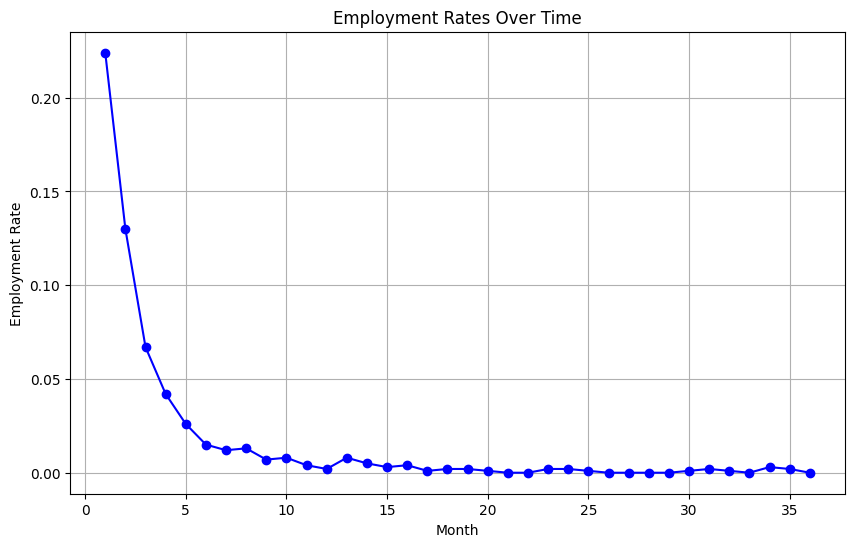

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def gev_distribution(scale=1, location=0):
    """ Generate a random luck factor for a job seeker based on a GEV distribution. """
    return np.random.gumbel(loc=location, scale=scale)

# Define simulation parameters
num_job_seekers = 1000
num_vacancies = 800
num_periods = 36  # Simulate for 12 months

# Initialize states
job_seekers = [{'employed': False, 'luck': gev_distribution()} for _ in range(num_job_seekers)]
vacancies = [True] * num_vacancies  # All vacancies are initially open

# Simulation loop
employment_history = []

for month in range(num_periods):
    employed_this_month = 0
    
    # Employers post new vacancies or close old ones
    for i in range(len(vacancies)):
        if not vacancies[i] and np.random.random() < 0.1:  # 10% chance of reopening a vacancy
            vacancies[i] = True
    
    # Job seekers make decisions
    for seeker in job_seekers:
        if not seeker['employed']:
            if np.random.random() < 0.5:  # 50% chance to apply for a job
                open_vacancies = [i for i, v in enumerate(vacancies) if v]
                if open_vacancies:
                    chosen_vacancy = np.random.choice(open_vacancies)
                    if np.random.random() < seeker['luck']:  # Luck factor influences getting the job
                        seeker['employed'] = True
                        vacancies[chosen_vacancy] = False
                        employed_this_month += 1
    
    employment_history.append(employed_this_month / num_job_seekers)

# Plotting the employment rates
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_periods + 1), employment_history, marker='o', linestyle='-', color='b')
plt.title('Employment Rates Over Time')
plt.xlabel('Month')
plt.ylabel('Employment Rate')
plt.grid(True)
plt.show()
